# Zrozumienie i analiza problemu, który prezentują dane
* Zapoznanie się z wybranym zestawem danych i opisem zadania do wykonania
* Pobranie bazy danych na swój komputer
* Zdefiniowanie co wiemy na dany temat 
* Efektem tego punktu powinien być krótki 1-2 stronicowy wstęp teoretyczny analizujący problem od strony biznesowej/merytorycznej

In [1]:
import numpy as np
import pandas as pd

import scipy

%matplotlib inline

import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.decomposition import PCA


from sklearn.ensemble import RandomForestRegressor as RFR
from sklearn.linear_model import Ridge, Lasso
from sklearn.linear_model import LinearRegression 
from sklearn.preprocessing import PolynomialFeatures

from sklearn.pipeline import Pipeline

from sklearn.metrics import mean_absolute_error as mae
from sklearn.metrics import mean_squared_error as mse
from sklearn.metrics import r2_score as r2

# import joblib # Zapisywanie modelu
import warnings
warnings.filterwarnings('ignore')

In [3]:
#import data
X_train = pd.read_csv("data\\life_expectancy.csv", sep = ";") 
X_train.head(5)

,Country,Status,Life expectancy,Adult Mortality,infant deaths,Alcohol,percentage expenditure,Hepatitis B,Measles,BMI,...,Polio,Total expenditure,Diphtheria,HIV/AIDS,GDP,Population,thinness 1-19 years,thinness 5-9 years,Income composition of resources,Schooling
0,Afghanistan,Developing,65.0,263.0,62,0.01,71.279624,65.0,1154,19.1,...,6.0,8.16,65.0,0.1,584.259210,33736494.0,17.2,17.3,0.479,10.1
1,Albania,Developing,77.8,74.0,0,4.60,364.975229,99.0,0,58.0,...,99.0,6.00,99.0,0.1,3954.227830,28873.0,1.2,1.3,0.762,14.2
2,Algeria,Developing,75.6,19.0,21,NaN,0.000000,95.0,63,59.5,...,95.0,NaN,95.0,0.1,4132.762920,39871528.0,6.0,5.8,0.743,14.4
3,Angola,Developing,52.4,335.0,66,NaN,0.000000,64.0,118,23.3,...,7.0,NaN,64.0,1.9,3695.793748,2785935.0,8.3,8.2,0.531,11.4
4,Antigua and Barbuda,Developing,76.4,13.0,0,NaN,0.000000,99.0,0,47.7,...,86.0,NaN,99.0,0.2,13566.954100,100772.0,3.3,3.3,0.784,13.9


In [ ]:
X_train.shape

###### data info
* Country - państwo
* Status - kraj rozwijający się / rozwinięty?
* Life expectancy - oczekiwana długość życia w latach
* Adult Mortality - śmiertelność wśród dorosłych, prawdopodobieństwo śmierci w wieku między 15 a 60 lat na 1000 osób
* infant deaths - śmiertelnośc noworodków w przeliczeniu na 1000 urodzeń
* Alcohol - konsumpcja alkoholu wśród osób 15+ [w litrach]
* percentage expenditure - udział wydatków na sektor zdrowia w PKB per capita
* Hepatitis B - udział zaszczepionych dzieci do 1 roku życia na WZW typu B
* Measles - liczba odnotowanych przypadków zachorowań na odrę na 1000 mieszkańców
* BMI
* under-five deaths - liczba śmierci na 1000 dzieci poniżej 5 roku życia
* Polio - udział zaszczepionych dzieci do 1 roku życia na Polio
* Total expenditure - udział wydatków na sektor zdrowia w całości wydatków rządowych
* Diphtheria - udział zaszczepionych dzieci do 1 roku życia na błonicę i krztusiec
* HIV/AIDS - śmierci dzieci poniżej 5 roku życia na 1 000 żywych urodzeń spowodowane HIV/AIDS
* GDP - PKB per capita
* Population - liczba mieszkańców
* thinness  1-19 years - rozpowszechnienie chudości w wieku 1 -19 lat
* thinness 5-9 years - rozpowszechnienie chudości w wieku 5 - 9 lat
* Income composition of resources - Wskaźnik rozwoju społecznego HDI Human Development Index

In [ ]:
X_train.info()

In [ ]:
X_train.describe()

In [ ]:
# y = lif["Life expectancy"]
# X = lif.drop(["Life expectancy","Total expenditure","Alcohol"], axis=1)

# X_train, X_test, y_train, y_test = train_test_split(X, y, train_size= 0.75, random_state= 42 )


# print("train = ", X_train.shape)
# print("test  = ",X_test.shape)
# X_train["Life expectancy"] = y_train

In [4]:
countri = X_train.Country
X_train = X_train.drop("Country", axis=1)

In [5]:
enc = OneHotEncoder()
enc.fit(X_train[["Status"]])

encoded_status = enc.transform(X_train[["Status"]]).toarray()
encoded_df = pd.DataFrame(encoded_status, columns=["Developed", "Developing"], 
                          index = X_train.index )
X_train = pd.concat([X_train, encoded_df], axis=1)
X_train.drop("Status", axis=1, inplace=True)

## feature cleaning

In [7]:
lost_data_percentiles = X_train.isnull().sum() / X_train.isnull().count()
lost_data_percentiles[lost_data_percentiles > 0]

Alcohol                            0.967213
Hepatitis B                        0.049180
BMI                                0.010929
Total expenditure                  0.989071
thinness 1-19 years                0.010929
thinness 5-9 years                 0.010929
Income composition of resources    0.054645
dtype: float64

In [9]:
missing_rows = X_train[np.isnan(X_train).any(axis = 1 )] # wiersze z brakującymi wartościami
print("len missing rows = ", missing_rows.shape[0])
print("number of missing data in individual columns :\n", missing_rows.isna().sum())
missing =  missing_rows.isna().sum()
missing = missing[missing > 0]
missing_rows[~np.isnan(missing_rows).all(axis = 1 )]

len missing rows =  181
number of missing data in individual columns :
 Life expectancy                      0
Adult Mortality                      0
infant deaths                        0
Alcohol                            177
percentage expenditure               0
Hepatitis B                          9
Measles                              0
BMI                                  2
under-five deaths                    0
Polio                                0
Total expenditure                  181
Diphtheria                           0
HIV/AIDS                             0
GDP                                  0
Population                           0
thinness 1-19 years                  2
thinness 5-9 years                   2
Income composition of resources     10
Schooling                            0
Developed                            0
Developing                           0
dtype: int64


,Life expectancy,Adult Mortality,infant deaths,Alcohol,percentage expenditure,Hepatitis B,Measles,BMI,under-five deaths,Polio,...,Diphtheria,HIV/AIDS,GDP,Population,thinness 1-19 years,thinness 5-9 years,Income composition of resources,Schooling,Developed,Developing
2,75.6,19.0,21,NaN,0.0,95.0,63,59.5,24,95.0,...,95.0,0.1,4132.762920,39871528.0,6.0,5.8,0.743,14.4,0.0,1.0
3,52.4,335.0,66,NaN,0.0,64.0,118,23.3,98,7.0,...,64.0,1.9,3695.793748,2785935.0,8.3,8.2,0.531,11.4,0.0,1.0
4,76.4,13.0,0,NaN,0.0,99.0,0,47.7,0,86.0,...,99.0,0.2,13566.954100,100772.0,3.3,3.3,0.784,13.9,0.0,1.0
5,76.3,116.0,8,NaN,0.0,94.0,0,62.8,9,93.0,...,94.0,0.1,13467.123600,43417765.0,1.0,0.9,0.826,17.3,0.0,1.0
6,74.8,118.0,1,NaN,0.0,94.0,33,54.9,1,96.0,...,94.0,0.1,369.654776,291695.0,2.1,2.2,0.741,12.7,0.0,1.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
178,74.1,157.0,9,NaN,0.0,87.0,0,62.1,10,87.0,...,87.0,0.1,3052.000000,30518260.0,1.6,1.5,0.769,14.3,0.0,1.0
179,76.0,127.0,28,NaN,0.0,97.0,256,17.5,35,97.0,...,97.0,0.1,4475.000000,100000000.0,14.2,14.5,0.678,12.6,0.0,1.0
180,65.7,224.0,37,NaN,0.0,69.0,468,41.3,47,63.0,...,69.0,0.1,891.000000,34277612.0,13.6,13.4,0.499,9.0,0.0,1.0
181,61.8,33.0,27,NaN,0.0,9.0,9,23.4,40,9.0,...,9.0,4.1,1313.889646,161587.0,6.3,6.1,0.576,12.5,0.0,1.0


In [10]:
mising = ''
for i in missing.index :
    mising += " " + "\'" + str(i) + "\'" + " : " + str(X_train[i].mean()) + ", "

mean_mising = eval( "{" + mising + "}" )
mean_mising

{'Alcohol': 5.288333333333333,
 'Hepatitis B': 82.42528735632185,
 'BMI': 42.75414364640884,
 'Total expenditure': 7.08,
 'thinness 1-19 years': 4.5348066298342555,
 'thinness 5-9 years': 4.575690607734807,
 'Income composition of resources': 0.6917398843930636}

In [11]:
X_train = X_train.fillna(value = mean_mising)
X_train.isna().sum()

Life expectancy                    0
Adult Mortality                    0
infant deaths                      0
Alcohol                            0
percentage expenditure             0
Hepatitis B                        0
Measles                            0
BMI                                0
under-five deaths                  0
Polio                              0
Total expenditure                  0
Diphtheria                         0
HIV/AIDS                           0
GDP                                0
Population                         0
thinness 1-19 years                0
thinness 5-9 years                 0
Income composition of resources    0
Schooling                          0
Developed                          0
Developing                         0
dtype: int64

###### data info
* Country - państwo
* Status - kraj rozwijający się / rozwinięty?
* Life expectancy - oczekiwana długość życia w latach
* Adult Mortality - śmiertelność wśród dorosłych, prawdopodobieństwo śmierci w wieku między 15 a 60 lat na 1000 osób
* infant deaths - śmiertelnośc noworodków w przeliczeniu na 1000 urodzeń
* Alcohol - konsumpcja alkoholu wśród osób 15+ [w litrach]
* percentage expenditure - udział wydatków na sektor zdrowia w PKB per capita
* Hepatitis B - udział zaszczepionych dzieci do 1 roku życia na WZW typu B
* Measles - liczba odnotowanych przypadków zachorowań na odrę na 1000 mieszkańców
* BMI
* under-five deaths - liczba śmierci na 1000 dzieci poniżej 5 roku życia
* Polio - udział zaszczepionych dzieci do 1 roku życia na Polio
* Total expenditure - udział wydatków na sektor zdrowia w całości wydatków rządowych
* Diphtheria - udział zaszczepionych dzieci do 1 roku życia na błonicę i krztusiec
* HIV/AIDS - śmierci dzieci poniżej 5 roku życia na 1 000 żywych urodzeń spowodowane HIV/AIDS
* GDP - PKB per capita
* Population - liczba mieszkańców
* thinness  1-19 years - rozpowszechnienie chudości w wieku 1 -19 lat
* thinness 5-9 years - rozpowszechnienie chudości w wieku 5 - 9 lat
* Income composition of resources - Wskaźnik rozwoju społecznego HDI Human Development Index

In [ ]:
X_train.describe()

BMI uznaliśmy za % nadwagi całej populacji ponieważ wysokość jest za skrajnia.

# Wstępne zapoznanie się z przedstawioną bazą danych
* Zapoznanie się z pobraną bazą danych (podłączenie się do niej przez Pythona z użyciem znanych pakietów pandas, numpy)
* Przygotowanie danych, a w tym:
* Podział na cechy numeryczne, kategoryczne
* Przygotowanie danych (pozbycie się lub transformacja wartości niekompletnych)
* Agregacja niezbędnych informacji
* Czyszczenie danych
* Transformacja, dyskretyzacja, skalowanie, grupowanie itp. – użyj to, czego dotyczy Twoje zagadnienie
* Wyświetlenie podstawowych statystyk (średnia, odchylenie standardowe, mediana) przydatnych do analizy problemu

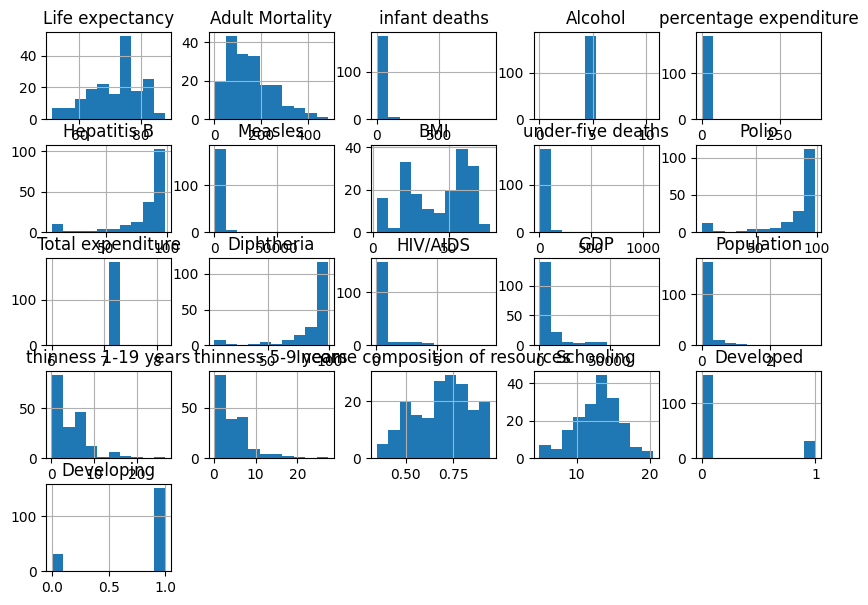

In [12]:
X_train.hist(figsize = (10,7)); 

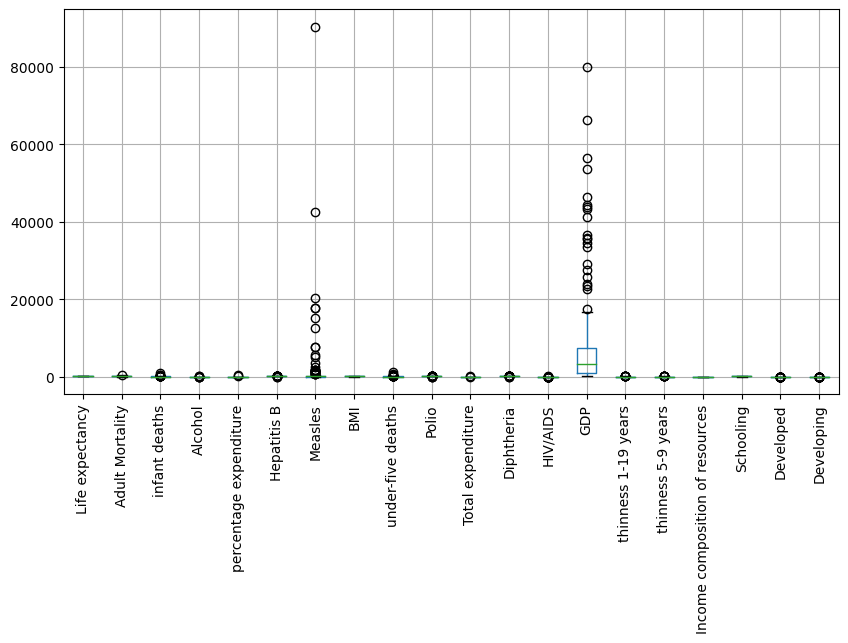

In [13]:
X_train.loc[:, X_train.columns != "Population" ].boxplot(figsize = (10,5))
plt.xticks(rotation=90);

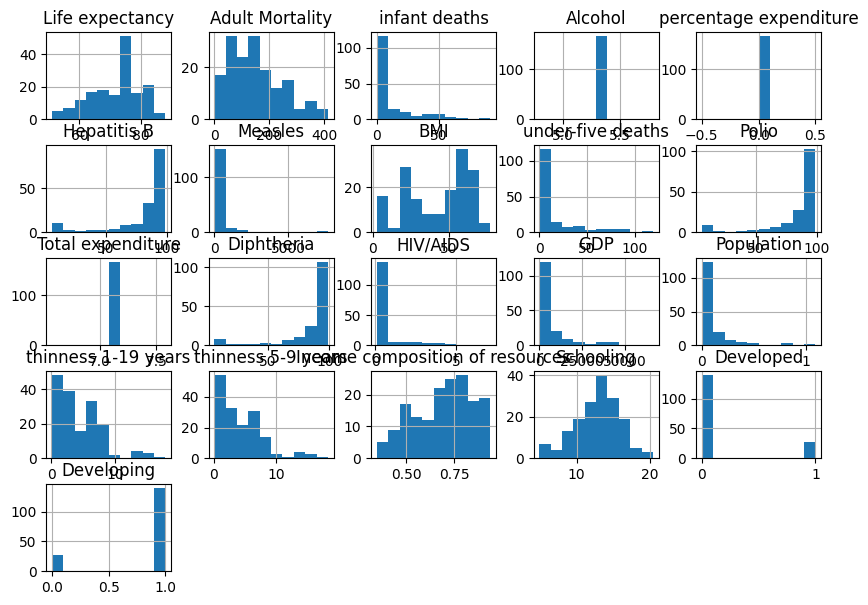

In [14]:
X = X_train.copy()

def outlier_boundary(X: np.array) -> tuple : 
    """
    Rozstęp międzykwartylowy IQR  (interquartile range, IQR) 
    to różnica między trzecim a pierwszym kwartylem
    returb: lower_boundary and upper_boundary
    """
    K = 1.5 
    q3 = np.quantile(X, .95)
    q1 = np.quantile(X, .05)
    iqr = q3 - q1

    lower_boundary = q1 - K * iqr
    upper_boundary =  q3 + K * iqr
    
    return lower_boundary, upper_boundary



outlier_indices = []
for column in X.columns:
    if column not in ["Developed", "Developing"]:
        lower_boundary, upper_boundary = outlier_boundary(X[column])
        outliers = X.loc[(X[column] < lower_boundary) | (X[column] > upper_boundary), column]

        outlier_indices.extend(outliers.index)
    
# выбросы 
X = X.loc[~X.index.isin(outlier_indices)].sort_index()
X.hist(figsize = (10,7));

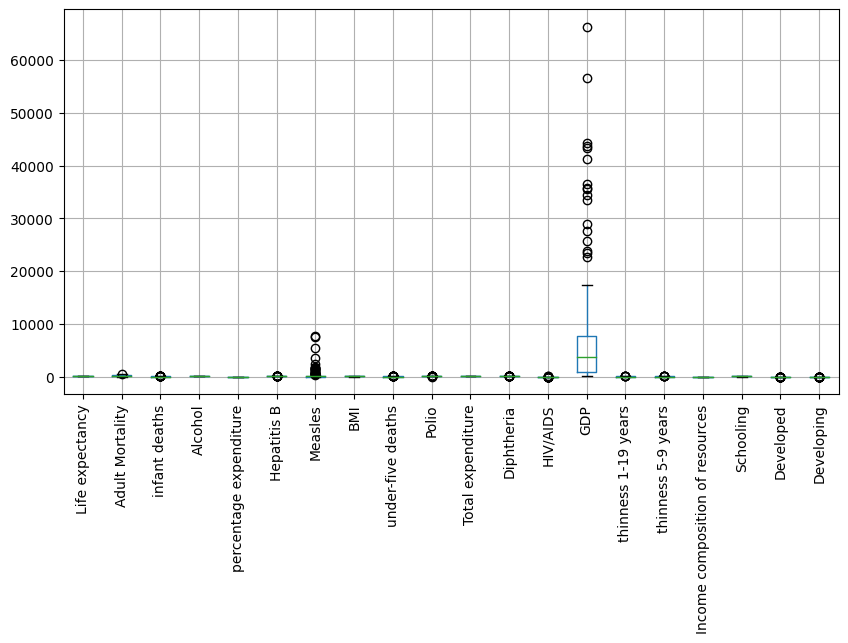

In [15]:
X.loc[:, X.columns != "Population" ].boxplot(figsize = (10,5))
plt.xticks(rotation=90);

###### Standaryzuj cechy, usuwając średnią i skalując do wariancji jednostkowej.

In [16]:
scaler = StandardScaler()
selected_columns = ~X.columns.isin(["Developed", "Developing"])
X[["Developed", "Developing"]] = X_train[["Developed", "Developing"]]

X.loc[:, selected_columns] = pd.DataFrame(scaler.fit_transform(X_train.loc[:, selected_columns]),  
                                          columns=X_train.loc[:, selected_columns].columns,
                                          index=X_train.loc[:, selected_columns].index)
X_train = X
X.head()

,Life expectancy,Adult Mortality,infant deaths,Alcohol,percentage expenditure,Hepatitis B,Measles,BMI,under-five deaths,Polio,...,Diphtheria,HIV/AIDS,GDP,Population,thinness 1-19 years,thinness 5-9 years,Income composition of resources,Schooling,Developed,Developing
2,0.491646,-1.375861,-0.033590,-1.330644e-15,-0.087049,0.538686,-0.184109,0.816256,-0.070819,0.487701,...,0.469009,-0.418081,-0.289336,0.657652,0.360381,0.295272,0.344653,0.543787,0.0,1.0
3,-2.372028,1.872018,0.505624,-1.330644e-15,-0.087049,-0.789318,-0.177076,-0.948268,0.617649,-3.151754,...,-0.933569,0.924178,-0.323272,-0.323374,0.926091,0.874091,-1.080752,-0.455339,0.0,1.0
4,0.590393,-1.437530,-0.285224,-1.330644e-15,-0.087049,0.710041,-0.192164,0.241080,-0.294107,0.115484,...,0.649987,-0.343511,0.443349,-0.394405,-0.303714,-0.307664,0.620321,0.377266,0.0,1.0
5,0.578050,-0.378886,-0.189363,-1.330644e-15,-0.087049,0.495847,-0.192164,0.977110,-0.210374,0.404987,...,0.423765,-0.418081,0.435596,0.751460,-0.869425,-0.886483,0.902713,1.509608,0.0,1.0
6,0.392899,-0.358329,-0.273241,-1.330644e-15,-0.087049,0.495847,-0.187944,0.592035,-0.284803,0.529059,...,0.423765,-0.418081,-0.581589,-0.389354,-0.598868,-0.572956,0.331206,-0.022385,0.0,1.0


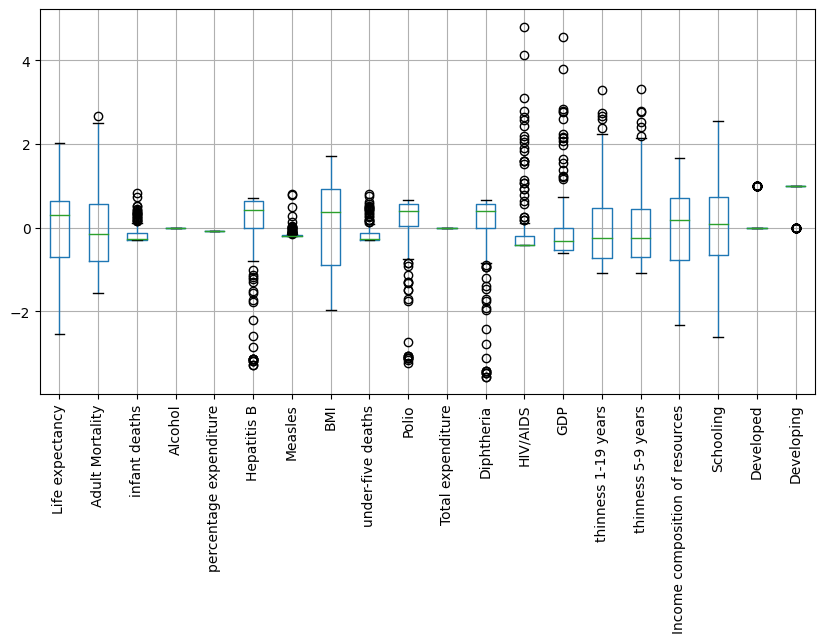

In [17]:
X.loc[:, X.columns != "Population" ].boxplot(figsize = (10,5))
plt.xticks(rotation=90);

###### correlations matrix

## feature selected

In [18]:
corr = X_train.corr("kendall")
corr.style.background_gradient(axis=0)

,Life expectancy,Adult Mortality,infant deaths,Alcohol,percentage expenditure,Hepatitis B,Measles,BMI,under-five deaths,Polio,Total expenditure,Diphtheria,HIV/AIDS,GDP,Population,thinness 1-19 years,thinness 5-9 years,Income composition of resources,Schooling,Developed,Developing
Life expectancy,1.000000,-0.613636,-0.415261,nan,nan,0.260484,-0.134899,0.369738,-0.424663,0.371876,nan,0.371950,-0.626509,0.402123,0.040615,-0.456040,-0.469054,0.691857,0.636346,0.429286,-0.429286
Adult Mortality,-0.613636,1.000000,0.353498,nan,nan,-0.151992,0.101948,-0.250815,0.357670,-0.226558,nan,-0.249124,0.453871,-0.265345,0.032555,0.264411,0.274717,-0.491024,-0.429939,-0.310656,0.310656
infant deaths,-0.415261,0.353498,1.000000,nan,nan,-0.213813,0.349699,-0.318963,0.965071,-0.277092,nan,-0.290928,0.392572,-0.339117,0.310707,0.353732,0.368539,-0.440989,-0.428253,-0.340154,0.340154
Alcohol,nan,nan,nan,1.000000,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan
percentage expenditure,nan,nan,nan,nan,1.000000,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan
Hepatitis B,0.260484,-0.151992,-0.213813,nan,nan,1.000000,-0.128162,0.110227,-0.212319,0.737156,nan,0.842911,-0.338565,0.161206,-0.014275,0.038072,0.007662,0.213790,0.212696,0.018987,-0.018987
Measles,-0.134899,0.101948,0.349699,nan,nan,-0.128162,1.000000,-0.104633,0.357715,-0.144127,nan,-0.138613,0.117306,-0.095347,0.174817,0.229071,0.245838,-0.105372,-0.125136,-0.016286,0.016286
BMI,0.369738,-0.250815,-0.318963,nan,nan,0.110227,-0.104633,1.000000,-0.312634,0.161631,nan,0.163382,-0.397897,0.310752,0.050744,-0.404275,-0.424490,0.428284,0.422355,0.245678,-0.245678
under-five deaths,-0.424663,0.357670,0.965071,nan,nan,-0.212319,0.357715,-0.312634,1.000000,-0.280023,nan,-0.291703,0.406840,-0.338699,0.307344,0.358097,0.369763,-0.446367,-0.436458,-0.330606,0.330606
Polio,0.371876,-0.226558,-0.277092,nan,nan,0.737156,-0.144127,0.161631,-0.280023,1.000000,nan,0.857143,-0.426126,0.222231,-0.031382,-0.087204,-0.113083,0.340026,0.319146,0.168479,-0.168479


In [19]:
corr.loc[ "Life expectancy", (corr["Life expectancy"] > .3) | ( corr["Life expectancy"] < -.3) ]

Life expectancy                    1.000000
Adult Mortality                   -0.613636
infant deaths                     -0.415261
BMI                                0.369738
under-five deaths                 -0.424663
Polio                              0.371876
Diphtheria                         0.371950
HIV/AIDS                          -0.626509
GDP                                0.402123
thinness 1-19 years               -0.456040
thinness 5-9 years                -0.469054
Income composition of resources    0.691857
Schooling                          0.636346
Developed                          0.429286
Developing                        -0.429286
Name: Life expectancy, dtype: float64

"Income composition of resources" ,  

[Feature importances with a forest of trees](https://scikit-learn.org/stable/auto_examples/ensemble/plot_forest_importances.html)

In [20]:
rfr = RFR(random_state=42)
rfr.fit(X_train.loc[:, X_train.columns != "Life expectancy"], X_train["Life expectancy"])

# Uzyskaj wartości ważności funkcji
feature_importance = rfr.feature_importances_
feature_importance_df = pd.DataFrame({'feature': X_train.loc[:, X_train.columns != "Life expectancy"].columns, 
                                      'importance': feature_importance})
feature_importance_df = feature_importance_df.sort_values(by='importance', ascending=False)

selected_features = feature_importance_df[feature_importance_df.importance > 0.0]
selected_features

,feature,importance
17,Schooling,0.372097
11,HIV/AIDS,0.247077
16,Income composition of resources,0.182723
0,Adult Mortality,0.128878
15,thinness 5-9 years,0.013599
12,GDP,0.009151
6,BMI,0.009130
14,thinness 1-19 years,0.008905
5,Measles,0.007398
13,Population,0.005531


[PCA](https://scikit-learn.org/stable/modules/generated/sklearn.decomposition.PCA.html)

In [21]:
pca = PCA(n_components = .95)
pca.fit(X_train.loc[:, X_train.columns != "Life expectancy"])

# Uzyskaj macierz komponentów (components_), która pokazuje znaczenie początkowych cech dla każdego komponentu
components = pca.components_

# Utwórz DataFrame dla wygody
components_df = pd.DataFrame(components, columns=X_train.loc[:, X_train.columns != "Life expectancy"].columns)


def top_components(components_df, top_n=3):
    n = 0
    print(f"Top-{top_n} najważniejsze funkcje każdego komponentu PCA:")
    for i in range(components_df.shape[0]):
        print(f"Komponenta {i + 1}:")
        n += 1
        top_features = components_df.loc[i].nlargest(top_n)
        for feature, importance in top_features.items():
            print(f"{feature}: {importance}")
        print("\n")
    return n
    
X_pca = pca.transform(X_train.loc[:, X_train.columns != "Life expectancy"])
lens = top_components(components_df, top_n=5)

Top-5 najważniejsze funkcje każdego komponentu PCA:
Komponenta 1:
Adult Mortality: 0.30778757268382223
HIV/AIDS: 0.27349250608508097
thinness 5-9 years: 0.23132510437132858
thinness 1-19 years: 0.22409129789638021
Developing: 0.08505765740737614


Komponenta 2:
BMI: 0.2783181326933012
Schooling: 0.16601420664562208
Income composition of resources: 0.1659600337637691
GDP: 0.1232896803168734
HIV/AIDS: 0.11390625915187981


Komponenta 3:
thinness 5-9 years: 0.45056534306389
thinness 1-19 years: 0.4245562716149197
Income composition of resources: 0.15087549147975943
GDP: 0.13298253693557763
Schooling: 0.12576901784886532


Komponenta 4:
GDP: 0.6478413321297917
HIV/AIDS: 0.4802498596385608
Adult Mortality: 0.3000707603117408
thinness 1-19 years: 0.28346831127693267
thinness 5-9 years: 0.2601183104836988


Komponenta 5:
Polio: 0.28624373207934356
HIV/AIDS: 0.24033172018252966
Schooling: 0.155206414198436
Developed: 0.13446507610166022
Income composition of resources: 0.1318406881084187


Kom

In [23]:
X_train_pca = pd.DataFrame(X_pca, columns=[ f'PCA{i}' for i in range(1, lens+1) ], index= X_train.index)
X_train_pca["Life expectancy"] = X_train[["Life expectancy"]]
X_train_pca

,PCA1,PCA2,PCA3,PCA4,PCA5,PCA6,PCA7,PCA8,PCA9,Life expectancy
2,-1.282755,-0.556323,0.963177,-0.168193,-0.741600,-0.469239,-0.439284,-0.462958,0.763429,0.491646
3,3.752148,0.611419,0.123045,0.546536,-0.572956,0.139008,2.396170,0.155712,-0.051228,-2.372028
4,-1.626604,-0.190753,0.543167,-0.279684,0.059850,0.413979,0.067451,-0.851891,-0.095176,0.590393
5,-2.295062,0.628239,-0.346324,0.177765,-0.283437,-0.284947,0.189905,0.263662,0.670457,0.578050
6,-1.029945,-0.152445,-0.548897,-0.777115,-0.341735,-0.173168,-0.376072,-0.194871,-0.201403,0.392899
...,...,...,...,...,...,...,...,...,...,...
178,-1.111445,0.558405,-0.602780,-0.399056,-0.636415,-0.348989,-0.047569,0.327344,0.409001,0.306495
179,0.895837,-2.899130,2.303269,0.897446,-0.182541,-0.684287,0.057958,0.849157,1.852296,0.541020
180,2.967654,-1.220631,1.644503,0.491278,-1.537039,-0.065343,-0.014820,0.681297,0.189364,-0.730353
181,4.186464,3.875512,1.995941,0.098085,0.849618,-0.588336,0.494685,-1.852173,0.423621,-1.211747


In [24]:
X_train.loc[:, X_train.columns != "Life expectancy"].columns

Index(['Adult Mortality', 'infant deaths', 'Alcohol', 'percentage expenditure',
       'Hepatitis B', 'Measles', 'BMI', 'under-five deaths', 'Polio',
       'Total expenditure', 'Diphtheria', 'HIV/AIDS', 'GDP', 'Population',
       'thinness 1-19 years', 'thinness 5-9 years',
       'Income composition of resources', 'Schooling', 'Developed',
       'Developing'],
      dtype='object')

# Podsumowanie kroku 2. i 3. oraz dokładne opisanie i przedstawienie hipotez, które będą rozwiązywane
* Zebranie wyników z punktu 3. i wiedzy z punktu 2.
* Opis tego, co zamierzamy zrobić wykorzystując zdobyte informacje
* Opis czego nie możemy zrobić na danej bazie danych z uwagi np. na brak informacji, zbyt dużo wartości odstających
* Podanie kilku algorytmów/modeli uczenia maszynowego rozwiązujących problemy regresji, który będziemy chcieli użyć w tym projekcie

In [25]:
rfr = RFR(criterion="squared_error", random_state= 42, n_jobs = -1)
ridge = Ridge(random_state= 42)
lasso = Lasso(random_state= 42 )

regressor = LinearRegression()
poly = PolynomialFeatures()

[Random Forest Regressor](https://scikit-learn.org/stable/modules/generated/sklearn.ensemble.RandomForestRegressor.html)

In [26]:
params = {
    "n_estimators": range(100,500,50),
    "max_depth" : range(2,8,1),
    "bootstrap" : [True, False]
}

clf_rfr = GridSearchCV(rfr , param_grid= params, cv= 5, scoring='neg_mean_squared_error')

[Ridge](https://scikit-learn.org/stable/modules/generated/sklearn.linear_model.Ridge.html)

In [27]:
params = {
    'alpha': np.arange(10.0, 20.0, 0.001),
    'fit_intercept': [True, False],
}

clf_ridge = GridSearchCV( ridge, param_grid=params, cv= 5, scoring='neg_mean_squared_error')

[Lasso](https://scikit-learn.org/stable/modules/generated/sklearn.linear_model.Lasso.html)

In [28]:
params = {
    'alpha': np.arange(0.001, 1.0, 0.0025),
    'fit_intercept': [True, False]
}


clf_lasso = GridSearchCV(  lasso, param_grid=params, cv= 5, scoring='neg_mean_squared_error')

### train_test_split

In [95]:
y = X_train_pca["Life expectancy"]
X = X_train_pca.drop(["Life expectancy"], axis=1)

X_train, X_test, y_train, y_test = train_test_split(X, y, train_size= 0.75, random_state= 42 )


print("train = ", X_train.shape)
print("test  = ",X_test.shape)


train =  (124, 9)
test  =  (42, 9)


##### trenujemy GridSearchCV

In [89]:
clf_rfr.fit(X_train,y_train)
clf_ridge.fit(X_train,y_train)
clf_lasso.fit(X_train,y_train)

KeyboardInterrupt: 

In [48]:
print("clf_rfr", clf_rfr.best_params_)
print("clf_ridge", clf_ridge.best_params_)
print("clf_lasso", clf_lasso.best_params_)

clf_rfr {'bootstrap': True, 'max_depth': 6, 'n_estimators': 100}
clf_ridge {'alpha': 10.0, 'fit_intercept': False}
clf_lasso {'alpha': 0.001, 'fit_intercept': False}
clf_poly {'poly__degree': 2, 'poly__include_bias': True, 'poly__interaction_only': False}


In [82]:
rfr = RFR( bootstrap=True, max_depth=6,
          n_estimators=100, random_state= 42, n_jobs= -1)

ridge = Ridge(alpha =  10.0, fit_intercept= False, random_state= 42)
lasso = Lasso(alpha= 0.001, fit_intercept= False , random_state= 42)

In [90]:
rfr.fit(X_train, y_train)
ridge.fit(X_train, y_train)
lasso.fit(X_train, y_train)

# scor

In [85]:
def scor(y_true, y_pred) -> None:
    print("r2", round(r2(y_true=y_true, y_pred=y_pred), 2))
    print("mae", round(mae(y_true=y_true, y_pred=y_pred), 2))
    print("rmse", round(np.sqrt(mae(y_true=y_true, y_pred=y_pred)), 2))
    print()

###### predict

In [91]:
y_pred_rfr = rfr.predict(X_train)
y_pred_ridge = ridge.predict(X_train)
y_pred_lasso = lasso.predict(X_train)


In [92]:
for y_pred, name_metod in zip((y_pred_rfr, y_pred_ridge, y_pred_lasso),
                             ('rfr', 'ridge', 'lasso')) :
    print(name_metod)
    scor(y_train, y_pred)
    print()

rfr
r2 0.96
mae 0.15
rmse 0.38


ridge
r2 0.85
mae 0.28
rmse 0.53


lasso
r2 0.85
mae 0.28
rmse 0.53




In [93]:
y_pred_rfr   = rfr.predict(X_test)
y_pred_ridge = ridge.predict(X_test)
y_pred_lasso = lasso.predict(X_test)


In [98]:
for y_pred, name_metod in zip((y_pred_rfr, y_pred_ridge, y_pred_lasso),
                             ('rfr', 'ridge', 'lasso')) :
    print(name_metod)
    scor(y_test, y_pred)
    print()

rfr
r2 0.86
mae 0.33
rmse 0.57


ridge
r2 0.91
mae 0.28
rmse 0.53


lasso
r2 0.91
mae 0.28
rmse 0.53




###### vizualization

In [101]:
# Obliczamy różnicę między rzeczywistymi a przewidywanymi wartościami
diff_rfr = y_test - y_pred_rfr
diff_ridge = y_test - y_pred_ridge
diff_lasso = y_test - y_pred_lasso
# diff_pol = y - pol_pred

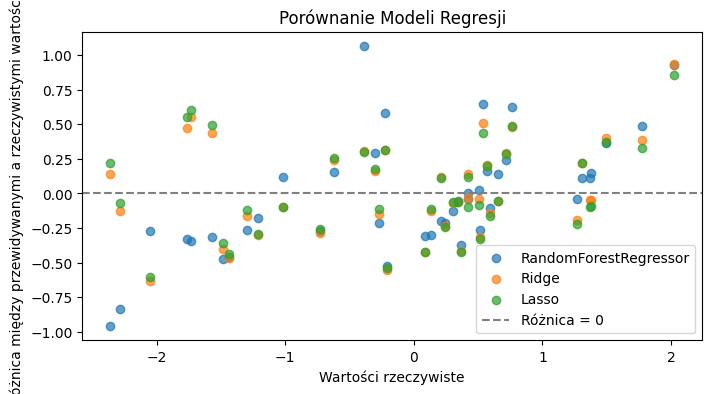

In [103]:
plt.figure(figsize=(8, 4))

# Dodajemy dane na wykres
plt.scatter(y_test, diff_rfr, label='RandomForestRegressor', alpha=0.7)
plt.scatter(y_test, diff_ridge, label='Ridge', alpha=0.7)
plt.scatter(y_test, diff_lasso, label='Lasso', alpha=0.7)

# Dodajemy linię zerową
plt.axhline(0, linestyle='--', color='gray', label='Różnica = 0')

# Dodajemy opisy osi i tytuł wykresu
plt.xlabel('Wartości rzeczywiste')
plt.ylabel('Różnica między przewidywanymi a rzeczywistymi wartościami')
plt.legend()
plt.title('Porównanie Modeli Regresji')

# Pokazujemy wykres
plt.show()


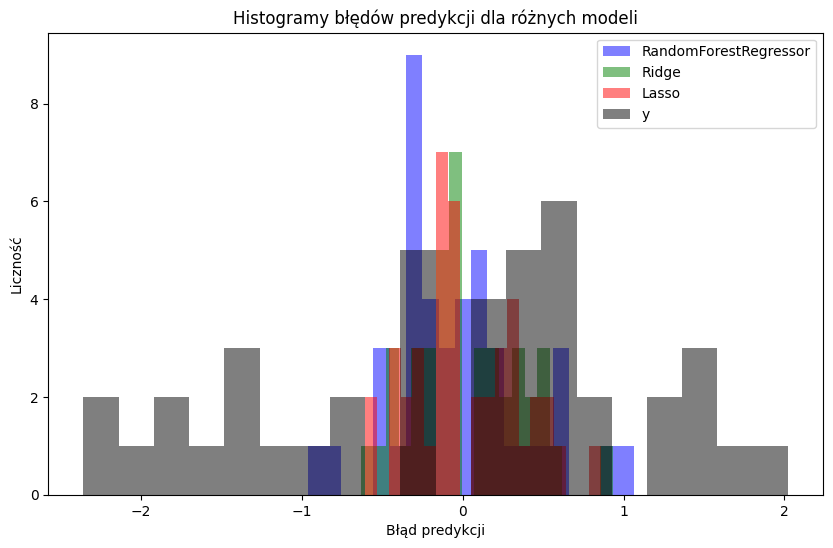

In [106]:
plt.figure(figsize=(10, 6))

plt.hist(diff_rfr, bins=20, alpha=0.5, label='RandomForestRegressor', color='blue')
plt.hist(diff_ridge, bins=20, alpha=0.5, label='Ridge', color='green')
plt.hist(diff_lasso, bins=20, alpha=0.5, label='Lasso', color='red')


plt.hist(y_test, bins=20, alpha=0.5, label='y', color='black')

# Dodajemy opisy osi i tytuł wykresu
plt.xlabel('Błąd predykcji')
plt.ylabel('Liczność')
plt.legend()
plt.title('Histogramy błędów predykcji dla różnych modeli')

# Pokazujemy wykres
plt.show()